In [2]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import random
import datetime

from qiskit.result import QuasiDistribution
from qiskit_aer.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver, QAOA
from qiskit_algorithms.optimizers import COBYLA, SPSA, POWELL
from qiskit_finance.data_providers import RandomDataProvider
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.noise import NoiseModel, depolarizing_error

Definition of the necessary functions

In [3]:
def get_famous_tickers(n):
    """
    Returns 'n' tickers from a predefined pool. 
    The selection is randomized but deterministic (always returns the same set for the same n).
    """
    # 1. Define your large pool of stocks
    ticker_pool = [
        "AAPL", "MSFT", "GOOG", "AMZN", "META", "TSLA", "NVDA", "NFLX",  # Tech
        "JPM", "BAC", "V", "MA", "GS",                                   # Finance
        "WMT", "COST", "PG", "KO", "PEP", "MCD",                         # Consumer
        "JNJ", "PFE", "MRK", "UNH",                                      # Healthcare
        "DIS", "ADBE", "CRM", "INTC", "AMD", "IBM", "ORCL"               # Others
    ]
    
    # Check if we have enough stocks
    if n > len(ticker_pool):
        raise ValueError(f"Requesting {n} tickers, but pool only has {len(ticker_pool)}.")

    # 2. Create a specific random number generator with a FIXED seed
    rng = random.Random(42) 
    
    # 3. Shuffle the entire pool deterministically
    shuffled_pool = ticker_pool[:]
    rng.shuffle(shuffled_pool)
    
    # 4. Return the top n
    return shuffled_pool[:n]

def get_portfolio_data(tickers, start_date, end_date, num_assets):
    """
    Fetches historical data and calculates expected return (mu) and covariance (sigma).
    """
    
    if tickers == []:
        #Fetch random data from qiskit finance
        seed = 1234
        tickers = [("TICKER%s" % i) for i in range(num_assets)]
        data = RandomDataProvider(
        tickers=tickers,
        start=datetime.datetime(2016, 1, 1),
        end=datetime.datetime(2016, 1, 30),
        seed=seed,
        )
        data.run()
        mu = data.get_period_return_mean_vector()
        sigma = data.get_period_return_covariance_matrix()
    else:
        #Fetch raw data from Yahoo Finance
        data = yf.download(tickers, start=start_date, end=end_date)['Close']
        
        #Calculate daily returns (percentage change)
        daily_returns = data.pct_change().dropna()
        
        #Calculate Mean Vector (mu) and Covariance Matrix (sigma)
        '''252 because if not, mu is the average daily returns and overall we want annual returns because it makes more sense.
        So just multiply the average daily returns by the 252 annual trading days'''
        mu = daily_returns.mean() * 252
        sigma = daily_returns.cov() * 252
    
    return mu, sigma, data

def normalize_data(mu, sigma):
    """
    Normalizes data to [0, 1] range.
    """
    mu_min = mu.min()
    mu_max = mu.max()
    mu_normalized = (mu - mu_min) / (mu_max - mu_min) #Normalization between [0,1]

    sigma_max = sigma.max().max()
    sigma_normalized = sigma / sigma_max #Normalization of sigma
    
    return mu_normalized, sigma_normalized

def create_portfolio_qp(mu, sigma, q=0.5, budget=None):
    """
    Creates a Quadratic Program for the Portfolio Optimization problem.
    
    Args:
        mu (numpy.ndarray): Expected returns vector.
        sigma (numpy.ndarray): Covariance matrix.
        q (float): Risk factor (0 = high risk/high return, 1 = low risk).
        budget (int): Number of assets to select. If None, defaults to half the assets.
        
    Returns:
        qp (QuadraticProgram): The mathematical formulation of the problem.
        penalty (float): The recommended penalty scaling factor for QUBO conversion.
    """
    num_assets = len(mu)
    
    mu_arr = mu.values if hasattr(mu, 'values') else mu
    sigma_arr = sigma.values if hasattr(sigma, 'values') else sigma

    if budget is None:
        budget = num_assets // 2
    
    # Create the portfolio instance
    portfolio = PortfolioOptimization(
        expected_returns=mu_arr, 
        covariances=sigma_arr, 
        risk_factor=q, 
        budget=budget
    )
    
    # Convert to Qiskit's QuadraticProgram format
    qp = portfolio.to_quadratic_program()
    
    return qp, portfolio

def print_result(result,portfolio):
    selection = result.x
    value = result.fval
    print("Optimal: selection {}, value {:.4f}".format(selection, value))

    eigenstate = result.min_eigen_solver_result.eigenstate
    probabilities = (
        eigenstate.binary_probabilities()
        if isinstance(eigenstate, QuasiDistribution)
        else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
    )
    print("\n----------------- Full result ---------------------")
    print("selection\tvalue\t\tprobability")
    print("---------------------------------------------------")
    probabilities = sorted(probabilities.items(), key=lambda x: x[1], reverse=True)

    for k, v in probabilities:
        x = np.array([int(i) for i in list(reversed(k))])
        value = portfolio.to_quadratic_program().objective.evaluate(x)
        print("%10s\t%.4f\t\t%.4f" % (x, value, v))

def get_aproximation_ratio(solution_result, mu, sigma, q, budget,greedy=False, energy = None):
    """
    Computes the approximation ratio: (C_max - C_obj) / (C_max - C_min)
    """
    
    # Check if inputs are Pandas types (have a .values attribute) and convert if so
    mu_arr = mu.values if hasattr(mu, 'values') else mu
    sigma_arr = sigma.values if hasattr(sigma, 'values') else sigma

    # 1. Compute the TRUE MINIMUM (Best possible value)
    portfolio_min = PortfolioOptimization(
        expected_returns=mu_arr,
        covariances=sigma_arr,    
        risk_factor=q, 
        budget=budget
    )
    qp_min = portfolio_min.to_quadratic_program()
    exact_mes = NumPyMinimumEigensolver()
    exact_optimizer = MinimumEigenOptimizer(exact_mes)
    result_min = exact_optimizer.solve(qp_min)
    c_min = result_min.fval

    # 2. Compute the TRUE MAXIMUM (Worst possible value)
    portfolio_max = PortfolioOptimization(
        expected_returns=-mu_arr, 
        covariances=-sigma_arr, 
        risk_factor=q, 
        budget=budget
    )
    qp_max = portfolio_max.to_quadratic_program()
    result_max = exact_optimizer.solve(qp_max)
    c_max = -result_max.fval 

    # 3. Get the QAOA Value
    if greedy and energy is None:
        raise ValueError("For greedy=True, energy must be provided.")
    if greedy:
        c_obj = energy
    else:
        c_obj = solution_result.fval

    # 4. Calculate Ratio
    denominator = c_max - c_min
    if abs(denominator) < 1e-9:
        return 0.0
        
    ratio = (c_max - c_obj) / denominator
    return ratio

def run_qaoa_experiments(qp, penalty, reps, optimizers_to_test, mu, sigma, q, budget):
    """
    Runs QAOA experiments using multiple classical optimizers and calculates performance metrics.

    This function iterates through the provided optimizers, solving the given Portfolio
    Optimization problem (QP) with the QAOA algorithm. It returns a dictionary containing
    probabilities, the optimal bitstring found, the objective value, the calculated
    approximation ratio, AND the probability of finding the exact optimal solution for each run.

    Args:
        qp (QuadraticProgram): The portfolio optimization problem to solve.
        penalty (float): The penalty factor used for constraint enforcement.
        reps (int): The number of QAOA circuit layers (depth p).
        optimizers_to_test (dict): Dictionary mapping optimizer names (str) to Qiskit optimizer instances.
        mu (pd.Series or np.ndarray): Expected asset returns, used for benchmarking.
        sigma (pd.DataFrame or np.ndarray): Asset covariance matrix, used for benchmarking.
        q (float): Risk factor used in the portfolio problem formulation.
        budget (int): Budget constraint (number of assets to select).

    Returns:
        dict: A nested dictionary where keys are optimizer names and values are dictionaries containing:
            - "probs" (dict): Measurement probabilities sorted by value.
            - "optimal_str" (str): The bitstring of the optimal solution found by the optimizer.
            - "optimal_val" (float): The energy (objective value) of the solution.
            - "ratio" (float): The approximation ratio comparing the result to the true optimal.
            - "success_prob" (float): The specific probability of measuring the TRUE global optimal bitstring.
    """
    results_data = {}
    
    # We need the true optimal bitstring to check its probability in the QAOA results.
    exact_mes = NumPyMinimumEigensolver()
    exact_opt = MinimumEigenOptimizer(exact_mes)
    result_min = exact_opt.solve(qp)

    # Convert numpy array [1. 0. 1. 0.] to string "1010"
    true_optimal_str = "".join(str(int(x)) for x in result_min.x)
    
    print(f"Running QAOA experiments with reps={reps}...")
    print(f"True Optimal Target: {true_optimal_str}")
    print(f"{'Optimizer':<10} | {'Ratio C(Z)':<8} | {'Value':<10} | {'Best String':<10} | {'Success Prob':<12}")
    print("-" * 70)
    

    for label, optimizer in optimizers_to_test.items():
        # Reset seed for reproducibility
        algorithm_globals.random_seed = 1234
        
        sampler = Sampler(backend_options={"seed_simulator": 1234})

        qaoa_mes = QAOA(
            sampler=sampler, 
            optimizer=optimizer, 
            reps=reps,
        )
        qaoa = MinimumEigenOptimizer(qaoa_mes, penalty=penalty)
        result = qaoa.solve(qp)
        
        # Calculate Approximation Ratio
        ratio = get_aproximation_ratio(result, mu, sigma, q, budget)
        
        # Capture optimal string found by THIS optimizer run
        found_optimal_str = "".join(str(int(x)) for x in result.x)
        
        # Extract Probabilities
        eigenstate = result.min_eigen_solver_result.eigenstate
        probabilities = (
            eigenstate.binary_probabilities()
            if hasattr(eigenstate, 'binary_probabilities')
            else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
        )
        
        # Qiskit results can sometimes be Little reversed. Check both just in case.
        success_prob = probabilities.get(true_optimal_str, 0.0)
        if success_prob == 0.0:
            success_prob = probabilities.get(true_optimal_str[::-1], 0.0)

        sorted_probs = dict(sorted(probabilities.items(), key=lambda item: item[1], reverse=True))
        
        # Store Data
        results_data[label] = {
            "probs": sorted_probs,
            "optimal_str": found_optimal_str,
            "optimal_val": result.fval,
            "ratio": ratio,
            "success_prob": success_prob
        }
        
        # Print nicely formatted row
        print(f"{label:<10} | {ratio:.4f}   | {result.fval:.4f}     | {found_optimal_str:<11} | {success_prob:.4f}")
        
    return results_data

def solve_greedy(mu, sigma, budget, qp):
    """
    Implements a greedy heuristic that selects the top 'budget' assets based on
    the ratio of Expected Return / Standard Deviation (mu / sqrt(sigma_ii)).
    
    Returns:
        selection (np.array): Binary vector of the selection.
        value (float): The objective value of this selection in the QP context.
        ratio_str (str): The bitstring representation.
    """
    # 1. Handle Pandas vs Numpy types
    mu_arr = mu.values if hasattr(mu, 'values') else mu
    sigma_arr = sigma.values if hasattr(sigma, 'values') else sigma
    
    # 2. Calculate the Metric (Return / Volatility) for each asset
    ratios = []
    for i in range(len(mu_arr)):
        variance = sigma_arr[i][i]
        volatility = np.sqrt(variance)
        
        # Avoid division by zero
        if volatility > 1e-9:
            metric = mu_arr[i] / volatility
        else:
            metric = 0.0
        ratios.append(metric)
            
    # 3. Pick the Top 'Budget' Assets
    top_indices = np.argsort(ratios)[-budget:]
    
    # 4. Construct the Binary Selection Vector
    x = np.zeros(len(mu_arr))
    for idx in top_indices:
        x[idx] = 1.0
        
    # 5. Evaluate this selection using the SAME QP as the other solvers
    value = qp.objective.evaluate(x)
    
    # Create string representation (e.g. "1100")
    selection_str = "".join(str(int(i)) for i in x)
    
    return x, value, selection_str

def run_penalty_analysis(qp_base, reps, mu, sigma, q, budget, penalty_range):
    """
    Varies the penalty parameter and analyzes how it affects QAOA performance.
    
    Args:
        qp_base (QuadraticProgram): The base portfolio optimization problem.
        reps (int): Number of QAOA circuit layers (depth p).
        mu (pd.Series or np.ndarray): Expected asset returns.
        sigma (pd.DataFrame or np.ndarray): Asset covariance matrix.
        q (float): Risk factor in the portfolio problem.
        budget (int): Budget constraint (number of assets to select).
        penalty_range (list): List of penalty values to test.
    
    Returns:
        dict: Results organized by penalty value, each containing:
            - "ratio" (float): Approximation ratio for the solution.
            - "success_prob" (float): Probability of finding the exact optimal solution.
            - "optimal_str" (str): The bitstring of the best solution found.
            - "optimal_val" (float): The objective value of the solution.
    """
    results_by_penalty = {}
    
    # Find the true optimal solution once (independent of penalty)
    exact_mes = NumPyMinimumEigensolver()
    exact_opt = MinimumEigenOptimizer(exact_mes)
    result_min = exact_opt.solve(qp_base)
    true_optimal_str = "".join(str(int(x)) for x in result_min.x)
    
    print(f"True Optimal Target: {true_optimal_str}")
    print(f"{'Penalty':<10} | {'Ratio':<10} | {'Success Prob':<15} | {'Best String':<15}")
    print("-" * 60)
    
    for penalty in penalty_range:
        algorithm_globals.random_seed = 1234
        
        sampler = Sampler(backend_options={"seed_simulator": 1234})
        optimizer = SPSA(maxiter=100)
        
        qaoa_mes = QAOA(sampler=sampler, optimizer=optimizer, reps=reps)
        qaoa = MinimumEigenOptimizer(qaoa_mes, penalty=penalty)
        result = qaoa.solve(qp_base)
        
        # Calculate Approximation Ratio
        ratio = get_aproximation_ratio(result, mu, sigma, q, budget)
        
        # Extract optimal string found
        found_optimal_str = "".join(str(int(x)) for x in result.x)
        
        # Extract Probabilities
        eigenstate = result.min_eigen_solver_result.eigenstate
        probabilities = (
            eigenstate.binary_probabilities()
            if hasattr(eigenstate, 'binary_probabilities')
            else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
        )
        
        # Check for the true optimal solution probability
        success_prob = probabilities.get(true_optimal_str, 0.0)
        if success_prob == 0.0:
            success_prob = probabilities.get(true_optimal_str[::-1], 0.0)
        
        # Store results
        results_by_penalty[penalty] = {
            "ratio": ratio,
            "success_prob": success_prob,
            "optimal_str": found_optimal_str,
            "optimal_val": result.fval
        }
        
        print(f"{penalty:<10.1f} | {ratio:<10.4f} | {success_prob:<15.4f} | {found_optimal_str:<15}")
    
    return results_by_penalty

def run_noise_analysis_prob(qp, penalty, reps, noise_range,n_noise,budget_noise):
    """
    Runs QAOA with increasing noise and plots the PROBABILITY of finding the optimal solution.
    """
    success_probabilities = []
    
    # 1. First, find the True optimal string using the exact solver
    from qiskit_algorithms import NumPyMinimumEigensolver
    exact_result = MinimumEigenOptimizer(NumPyMinimumEigensolver()).solve(qp)

    # Convert [1. 0. 1. 0.] -> "1010" (No reversal needed for comparison if consistent)

    true_optimal_str = "".join(str(int(x)) for x in exact_result.x)
    
    print(f"True Optimal Target: {true_optimal_str}")
    print("-" * 60)
    print(f"{'Noise Prob':<15} | {'Success Prob':<15} | {'Top Found'}")

    for prob in noise_range:
        algorithm_globals.random_seed = 1234
        
        #Noise Model Setup
        noise_model = NoiseModel()
        error_1q = depolarizing_error(prob, 1)
        error_2q = depolarizing_error(prob, 2)
        noise_model.add_all_qubit_quantum_error(error_1q, ['u1', 'u2', 'u3', 'rz', 'sx', 'x'])
        noise_model.add_all_qubit_quantum_error(error_2q, ['cx'])
        
        #Run QAOA
        noisy_sampler = Sampler(
            backend_options={
                "noise_model": noise_model,
                "seed_simulator": 1234
            }
        )
        optimizer = POWELL(maxiter=100)
        qaoa_mes = QAOA(sampler=noisy_sampler, optimizer=optimizer, reps=reps)
        qaoa = MinimumEigenOptimizer(qaoa_mes, penalty=penalty)
        
        result = qaoa.solve(qp)
        
        #EXTRACT PROBABILITY
        eigenstate = result.min_eigen_solver_result.eigenstate
        probs = (
            eigenstate.binary_probabilities()
            if hasattr(eigenstate, 'binary_probabilities')
            else {k: np.abs(v) ** 2 for k, v in eigenstate.to_dict().items()}
        )
        
        
        # Try direct match first
        current_prob = probs.get(true_optimal_str, 0.0)
        
        # If 0, try checking the reverse key
        if current_prob == 0.0:
            current_prob = probs.get(true_optimal_str[::-1], 0.0)
            
        success_probabilities.append(current_prob)
        
        # Find what the most probable result actually was for logging
        top_found = max(probs, key=probs.get)
        
        print(f"{prob:<15.4f} | {current_prob:<15.4f} | {top_found}")

    #Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(noise_range, success_probabilities, marker='o', color='red', linewidth=2)
    plt.title(f"QAOA Robustness: Probability of Finding Optimal 'n = {n_noise}' 'budget = {budget_noise}'", fontsize=14)
    plt.xlabel("Depolarizing Noise Probability", fontsize=12)
    plt.ylabel("Probability of Optimal Solution", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

Data retrieval, Normalization and Creation of the QUBO problem

In [7]:
p = 3
n = 16
q = 0.9
budget = n//2
penalty = n

# Fetch and prepare data
tickers = get_famous_tickers(n)
print("Selected Tickers:", tickers)
mu, sigma, data = get_portfolio_data(tickers=tickers, start_date="2016-01-01", end_date="2016-12-30", num_assets=n)
mu_normalized, sigma_normalized = normalize_data(mu, sigma)

# Create Quadratic Program
qp_realdata, portfolio = create_portfolio_qp(mu_normalized, sigma_normalized, q=q, budget=budget)


Selected Tickers: ['JNJ', 'COST', 'V', 'INTC', 'UNH', 'NVDA', 'TSLA', 'GS', 'MA', 'PG', 'BAC', 'CRM', 'ORCL', 'MRK', 'KO', 'AMD']


C:\Users\andre\AppData\Local\Temp\ipykernel_7728\2140397681.py:49: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  16 of 16 completed


Testing different optmizers for the same problem and comparing them with the greedy algorithm

Running QAOA experiments with reps=3...
True Optimal Target: 0010101101101010
Optimizer  | Ratio C(Z) | Value      | Best String | Success Prob
----------------------------------------------------------------------
COBYLA     | 0.9471   | -0.1185     | 0000101101101011 | 0.0000
SPSA       | 0.8753   | 0.0951     | 0010101111110000 | 0.0000
POWELL     | 0.9765   | -0.2059     | 0010001111101010 | 0.0000

Greedy Solver Results:
Selection: 1100101001101010, Value: 0.4617, Ratio: 0.7520


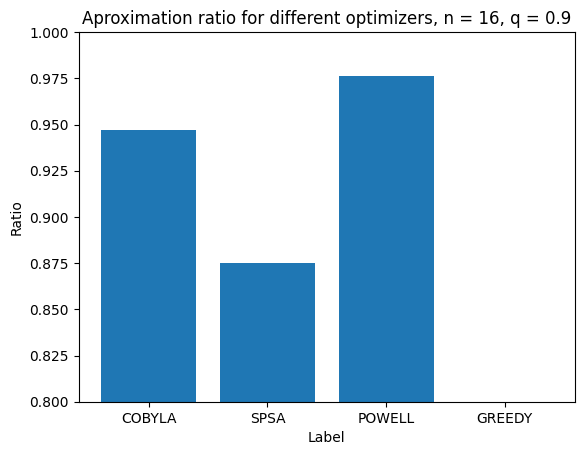

In [ ]:
# Run QAOA Experiments (test different optimizers)
iter=200
optimizers_to_test = {
        "COBYLA": COBYLA(maxiter=iter),
        "SPSA": SPSA(maxiter=iter),
        "POWELL": POWELL(maxiter=iter)
}

results_data = run_qaoa_experiments(qp=qp_realdata, penalty=penalty, reps=p, optimizers_to_test=optimizers_to_test,mu=mu_normalized, sigma=sigma_normalized, q=q, budget=budget)

# Greedy Solver
x, value, selection_str = solve_greedy(mu_normalized, sigma_normalized, budget, qp_realdata)
greedyr = get_aproximation_ratio(x, mu_normalized, sigma_normalized, q, budget,greedy=True,energy=value)
results_data["GREEDY"] = {
    "probs": {selection_str: 1.0},
    "optimal_str": selection_str,
    "optimal_val": value,
    "ratio": greedyr 
}

# Print Greedy Results
print("\nGreedy Solver Results:")
print(f"Selection: {selection_str}, Value: {value:.4f}, Ratio: {greedyr:.4f}")

# Plot QAOA Results
labels = list(results_data.keys())
ratios = [results_data[label]["ratio"] for label in labels]

plt.bar(labels, ratios)
plt.ylabel("Ratio")
plt.xlabel("Label")
plt.title(f"Aproximation ratio for different optimizers, n = {n}, q = {q}")
plt.ylim(0.8, 1)
plt.show()

Varying the number of iterations for each optimizer

In [9]:
p = 3
n = 10
q = 0.5
budget = n//2
penalty = n

# Fetch and prepare data
tickers = get_famous_tickers(n)
print("Selected Tickers:", tickers)
mu, sigma, data = get_portfolio_data(tickers=tickers, start_date="2016-01-01", end_date="2016-12-30", num_assets=n)
mu_normalized, sigma_normalized = normalize_data(mu, sigma)

# Create Quadratic Program
qp_realdata, portfolio = create_portfolio_qp(mu_normalized, sigma_normalized, q=q, budget=budget)

# Run QAOA experiments for different optimizer iteration counts
iter_values = [1, 5, 10, 50, 100, 200, 300, 500]
results_by_iter = {}

for it in iter_values:
    print(f"\n{'='*60}")
    print(f"Running QAOA with optimizer maxiter={it}")
    print(f"{'='*60}")
    
    opt_for_iter = {
        "COBYLA": COBYLA(maxiter=it),
        "SPSA": SPSA(maxiter=it),
        "POWELL": POWELL(maxiter=it)
    }
    
    results_by_iter[it] = run_qaoa_experiments(
        qp=qp_realdata,
        penalty=penalty,
        reps=p,
        optimizers_to_test=opt_for_iter,
        mu=mu_normalized,
        sigma=sigma_normalized,
        q=q,
        budget=budget
    )

# Display summary of approximation ratios across all iteration counts
print(f"\n{'='*60}")
print("Summary: Approximation Ratios by Optimizer Iterations")
print(f"{'='*60}")
print(f"{'Iter':<6} | {'COBYLA':<10} | {'SPSA':<10} | {'POWELL':<10}")
print("-" * 50)

for it in iter_values:
    cobyla_ratio = results_by_iter[it]["COBYLA"]["ratio"]
    spsa_ratio = results_by_iter[it]["SPSA"]["ratio"]
    powell_ratio = results_by_iter[it]["POWELL"]["ratio"]
    print(f"{it:<6} | {cobyla_ratio:<10.4f} | {spsa_ratio:<10.4f} | {powell_ratio:<10.4f}")

Selected Tickers: ['JNJ', 'COST', 'V', 'INTC', 'UNH', 'NVDA', 'TSLA', 'GS', 'MA', 'PG']


C:\Users\andre\AppData\Local\Temp\ipykernel_7728\2140397681.py:49: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  10 of 10 completed


Running QAOA with optimizer maxiter=1
Running QAOA experiments with reps=3...
True Optimal Target: 1001011010
Optimizer  | Ratio C(Z) | Value      | Best String | Success Prob
----------------------------------------------------------------------



c:\Users\andre\Documents\qc803-QAOAFinal\venv\Lib\site-packages\scipy\_lib\pyprima\common\preproc.py:68: UserWarning: COBYLA: Invalid MAXFUN; it should be at least num_vars + 2; it is set to 8
  warn(f'{solver}: Invalid MAXFUN; it should be at least {min_maxfun_str}; it is set to {maxfun}')


COBYLA     | 1.0000   | -0.2522     | 1001011010  | 0.0186
SPSA       | 1.0000   | -0.2522     | 1001011010  | 0.0078
POWELL     | 1.0000   | -0.2522     | 1001011010  | 0.0371

Running QAOA with optimizer maxiter=5
Running QAOA experiments with reps=3...
True Optimal Target: 1001011010
Optimizer  | Ratio C(Z) | Value      | Best String | Success Prob
----------------------------------------------------------------------


c:\Users\andre\Documents\qc803-QAOAFinal\venv\Lib\site-packages\scipy\_lib\pyprima\common\preproc.py:68: UserWarning: COBYLA: Invalid MAXFUN; it should be at least num_vars + 2; it is set to 8
  warn(f'{solver}: Invalid MAXFUN; it should be at least {min_maxfun_str}; it is set to {maxfun}')


COBYLA     | 1.0000   | -0.2522     | 1001011010  | 0.0186
SPSA       | 1.0000   | -0.2522     | 1001011010  | 0.0068
POWELL     | 1.0000   | -0.2522     | 1001011010  | 0.0439

Running QAOA with optimizer maxiter=10
Running QAOA experiments with reps=3...
True Optimal Target: 1001011010
Optimizer  | Ratio C(Z) | Value      | Best String | Success Prob
----------------------------------------------------------------------
COBYLA     | 1.0000   | -0.2522     | 1001011010  | 0.0186
SPSA       | 0.9045   | -0.0682     | 0001011011  | 0.0010
POWELL     | 1.0000   | -0.2522     | 1001011010  | 0.0439

Running QAOA with optimizer maxiter=50
Running QAOA experiments with reps=3...
True Optimal Target: 1001011010
Optimizer  | Ratio C(Z) | Value      | Best String | Success Prob
----------------------------------------------------------------------
COBYLA     | 1.0000   | -0.2522     | 1001011010  | 0.0010
SPSA       | 1.0000   | -0.2522     | 1001011010  | 0.0010
POWELL     | 1.0000   | -0.252

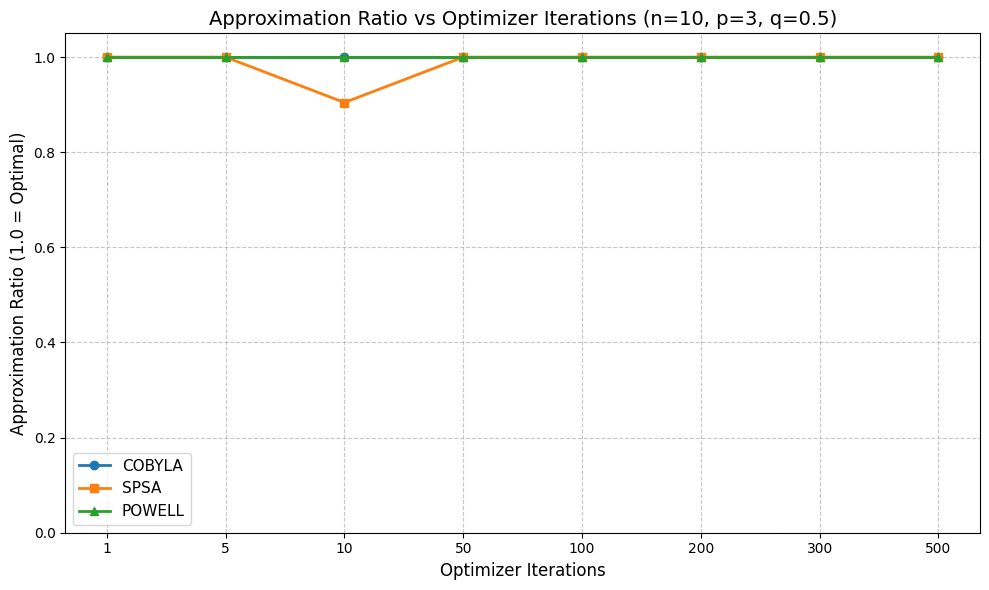

In [ ]:
# 1. Extract data for plotting
iter_values_list = sorted(list(results_by_iter.keys()))

cobyla_ratios = [results_by_iter[it]["COBYLA"]["ratio"] for it in iter_values_list]
spsa_ratios = [results_by_iter[it]["SPSA"]["ratio"] for it in iter_values_list]
powell_ratios = [results_by_iter[it]["POWELL"]["ratio"] for it in iter_values_list]

# 2. Plotting
plt.figure(figsize=(10, 6))

# Use an index for x-axis to keep spacing equal, but label them with the real values
x_positions = range(len(iter_values_list))

plt.plot(x_positions, cobyla_ratios, marker='o', label='COBYLA', linewidth=2)
plt.plot(x_positions, spsa_ratios, marker='s', label='SPSA', linewidth=2)
plt.plot(x_positions, powell_ratios, marker='^', label='POWELL', linewidth=2)

# Formatting
plt.xlabel("Optimizer Iterations", fontsize=12)
plt.ylabel("Approximation Ratio (1.0 = Optimal)", fontsize=12)
plt.title(f"Approximation Ratio vs Optimizer Iterations (n={n}, p={p}, q={q})", fontsize=14)

# Set the x-ticks to be the actual iteration numbers
plt.xticks(x_positions, iter_values_list)

plt.ylim(0, 1.05) # Keep y-axis standard
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

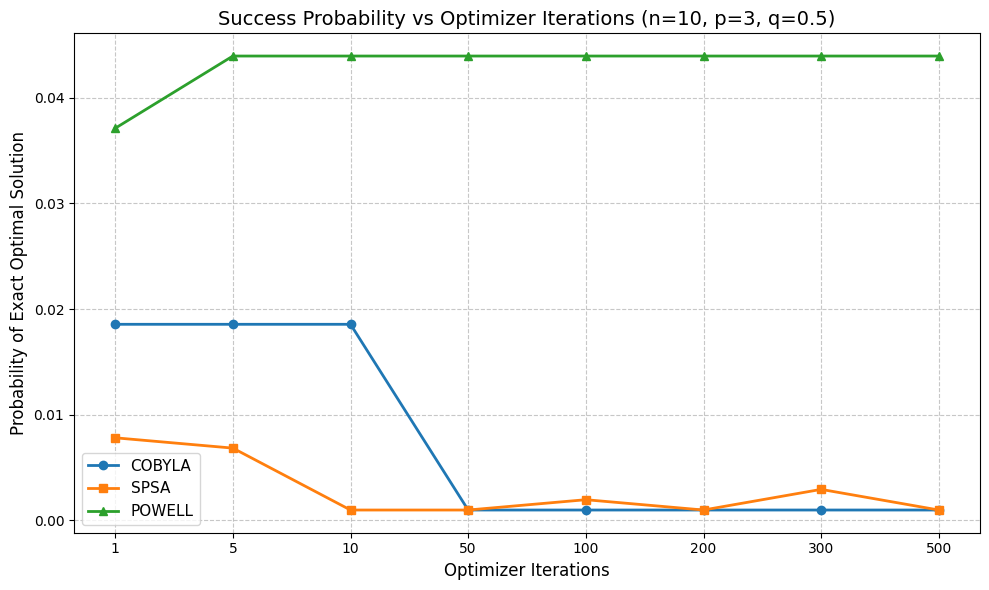

In [ ]:
# 1. Extract PROBABILITY data for plotting
iter_values_list = sorted(list(results_by_iter.keys()))

cobyla_probs = [results_by_iter[it]["COBYLA"]["success_prob"] for it in iter_values_list]
spsa_probs = [results_by_iter[it]["SPSA"]["success_prob"] for it in iter_values_list]
powell_probs = [results_by_iter[it]["POWELL"]["success_prob"] for it in iter_values_list]

# 2. Plotting
plt.figure(figsize=(10, 6))

# Use an index for x-axis to keep spacing equal, but label them with the real values
x_positions = range(len(iter_values_list))

plt.plot(x_positions, cobyla_probs, marker='o', label='COBYLA', linewidth=2)
plt.plot(x_positions, spsa_probs, marker='s', label='SPSA', linewidth=2)
plt.plot(x_positions, powell_probs, marker='^', label='POWELL', linewidth=2)

# Formatting
plt.xlabel("Optimizer Iterations", fontsize=12)
plt.ylabel("Probability of Exact Optimal Solution", fontsize=12) 
plt.title(f"Success Probability vs Optimizer Iterations (n={n}, p={p}, q={q})", fontsize=14)

# Set the x-ticks to be the actual iteration numbers
plt.xticks(x_positions, iter_values_list)

plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Varying the depht of the circuit, p

In [ ]:
n = 16
q = 0.5
budget = n//2
penalty = n

# Fetch and prepare data
tickers = get_famous_tickers(n)
print("Selected Tickers:", tickers)
mu, sigma, data = get_portfolio_data(tickers=tickers, start_date="2016-01-01", end_date="2016-12-30", num_assets=n)
mu_normalized, sigma_normalized = normalize_data(mu, sigma)

# Create Quadratic Program
qp_realdata, portfolio = create_portfolio_qp(mu_normalized, sigma_normalized, q=q, budget=budget)
results_by_p = {}
# Define optimizers to test
optimizers_to_test = {
        "COBYLA": COBYLA(maxiter=200),
        "SPSA": SPSA(maxiter=200),
        "POWELL": POWELL(maxiter=200)
    }
# Run QAOA experiments for different optimizer repetitions (p)
p_values = [1, 2, 3, 4, 5]
for p in p_values:
    print(f"\n{'='*60}")
    print(f"Running QAOA with p={p}")
    print(f"{'='*60}")
    
    results_by_p[p] = run_qaoa_experiments(
        qp=qp_realdata,
        penalty=penalty,
        reps=p,
        optimizers_to_test=optimizers_to_test,
        mu=mu_normalized,
        sigma=sigma_normalized,
        q=q,
        budget=budget
    )
# Display summary of approximation ratios across all iteration counts
print(f"\n{'='*60}")
print("Summary: Approximation Ratios by QAOA depth (p)")
print(f"{'='*60}")
print(f"{'p':<6} | {'COBYLA':<10} | {'SPSA':<10} | {'POWELL':<10}")
print("-" * 50)
for p in p_values:
    cobyla_ratio = results_by_p[p]["COBYLA"]["ratio"]
    spsa_ratio = results_by_p[p]["SPSA"]["ratio"]
    powell_ratio = results_by_p[p]["POWELL"]["ratio"]
    print(f"{p:<6} | {cobyla_ratio:<10.4f} | {spsa_ratio:<10.4f} | {powell_ratio:<10.4f}")

C:\Users\andre\AppData\Local\Temp\ipykernel_17424\2578063092.py:49: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[******************    38%                       ]  6 of 16 completed

Selected Tickers: ['JNJ', 'COST', 'V', 'INTC', 'UNH', 'NVDA', 'TSLA', 'GS', 'MA', 'PG', 'BAC', 'CRM', 'ORCL', 'MRK', 'KO', 'AMD']


[*********************100%***********************]  16 of 16 completed



Running QAOA with p=1
Running QAOA experiments with reps=1...
True Optimal Target: 1010101001101010
Optimizer  | Ratio C(Z) | Value      | Best String | Success Prob
----------------------------------------------------------------------
COBYLA     | 0.9032   | -0.9097     | 1010011100101010 | 0.0000
SPSA       | 0.9661   | -1.0312     | 1010001001111010 | 0.0000
POWELL     | 0.9468   | -0.9938     | 1000001111101010 | 0.0000

Running QAOA with p=2
Running QAOA experiments with reps=2...
True Optimal Target: 1010101001101010
Optimizer  | Ratio C(Z) | Value      | Best String | Success Prob
----------------------------------------------------------------------
COBYLA     | 0.9337   | -0.9687     | 1100001001111010 | 0.0000
SPSA       | 0.9390   | -0.9788     | 1010100101101010 | 0.0000
POWELL     | 0.8849   | -0.8744     | 1110100001101010 | 0.0000

Running QAOA with p=3
Running QAOA experiments with reps=3...
True Optimal Target: 1010101001101010
Optimizer  | Ratio C(Z) | Value      | 

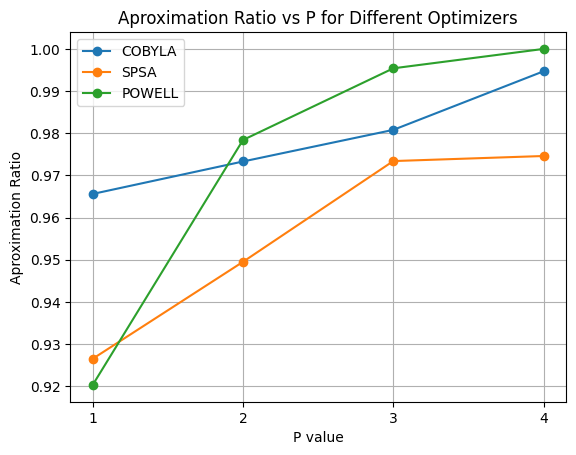

In [ ]:
# As it is shown in the box avobe, for p=5 it was impossible to compute the runs in a reasonable time,
# so we took the values of the aproximation ratios from the printed results and plotted them here:
p1 = [0.9656,0.9265,0.9203]
p2 = [0.9733,0.9495,0.9784]
p3 = [0.9808,0.9734,0.9954]
p4 = [0.9947,0.9746,1.0000]
datasets = [p1,p2,p3,p4]
indices = [1,2,3,4]
labels = ['COBYLA','SPSA','POWELL']
# Plot
plt.figure()

for i, label in enumerate(labels):
    values = [datasets[j][i] for j in range(len(indices))]
    plt.plot(indices, values, marker='o', label=label)

plt.xlabel("P value")
plt.ylabel("Aproximation Ratio")
plt.title("Aproximation Ratio vs P for Different Optimizers")
plt.legend()
plt.grid(True)
plt.xticks(indices)
plt.show()

Penalty Analysis

In [23]:
p = 3
n = 10
q = 0.5
budget = n//2

# Fetch and prepare data
tickers = get_famous_tickers(n)

mu, sigma, data = get_portfolio_data(tickers=tickers, start_date="2016-01-01", end_date="2016-12-30", num_assets=n)
mu_normalized, sigma_normalized = normalize_data(mu, sigma)

# Create Quadratic Program
qp_realdata, portfolio = create_portfolio_qp(mu_normalized, sigma_normalized, q=q, budget=budget)

# Run penalty analysis
penalty_range = [1, 3, 6, 8, 10, 20, 50]
results_by_penalty = run_penalty_analysis(
    qp_base=qp_realdata,
    reps=p,
    mu=mu_normalized,
    sigma=sigma_normalized,
    q=q,
    budget=budget,
    penalty_range=penalty_range
)

C:\Users\andre\AppData\Local\Temp\ipykernel_9584\1221950842.py:49: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  10 of 10 completed


True Optimal Target: 1001011010
Penalty    | Ratio      | Success Prob    | Best String    
------------------------------------------------------------
1.0        | 1.0000     | 0.0420          | 1001011010     
3.0        | 1.0000     | 0.0684          | 1001011010     
6.0        | 1.0000     | 0.0059          | 1001011010     
8.0        | 1.0000     | 0.0010          | 1001011010     
10.0       | 1.0000     | 0.0010          | 1001011010     
20.0       | 0.9874     | 0.0010          | 0101011010     
50.0       | 0.9355     | 0.0000          | 1101010010     


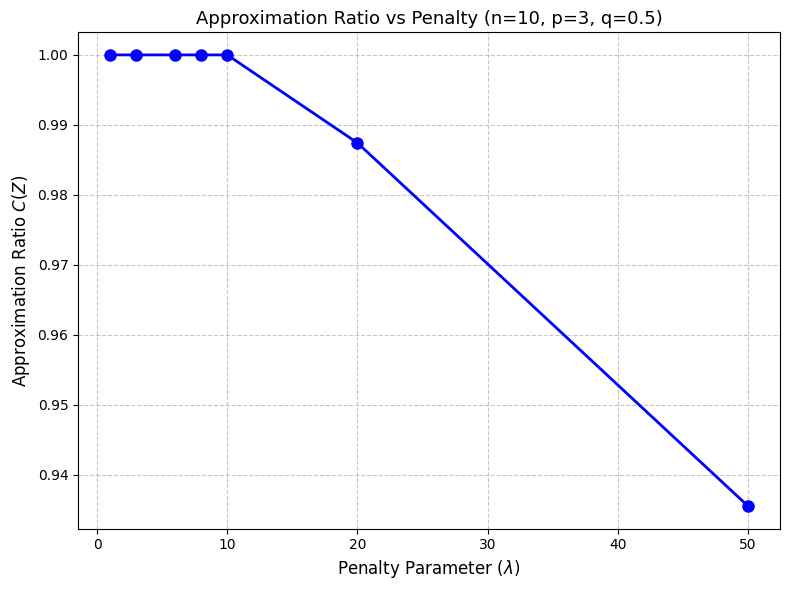

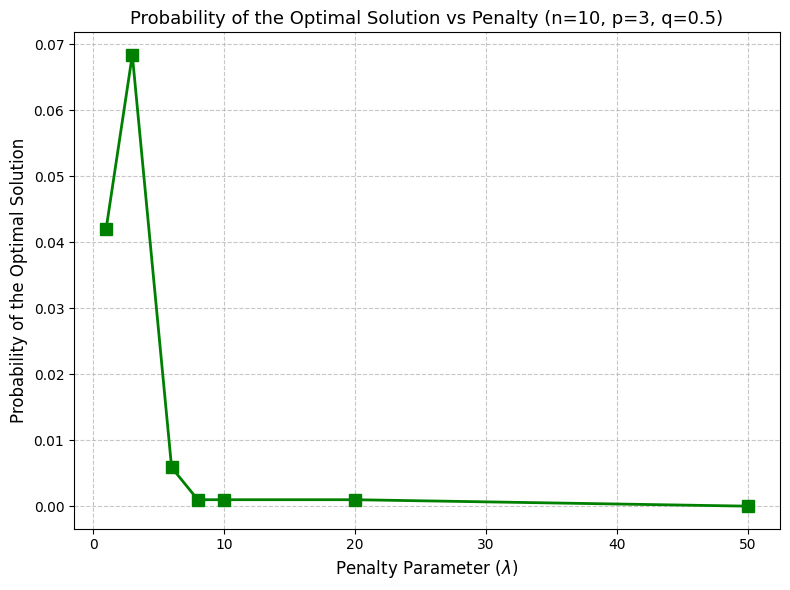

In [ ]:
# Extract data for plotting
penalties = sorted(results_by_penalty.keys())
ratios = [results_by_penalty[pen]["ratio"] for pen in penalties]
success_probs = [results_by_penalty[pen]["success_prob"] for pen in penalties]

# Aproximation Ratio vs Penalty
plt.figure(figsize=(8, 6))
plt.plot(penalties, ratios, marker='o', linewidth=2, markersize=8, color='blue')

#Labels
plt.xlabel(r"Penalty Parameter ($\lambda$)", fontsize=12)
plt.ylabel(r"Approximation Ratio $C(Z)$", fontsize=12)
plt.title(f"Approximation Ratio vs Penalty (n={n}, p={p}, q={q})", fontsize=13)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#Success Probability vs Penalty
plt.figure(figsize=(8, 6))
plt.plot(penalties, success_probs, marker='s', linewidth=2, markersize=8, color='green')

#Labels
plt.xlabel(r"Penalty Parameter ($\lambda$)", fontsize=12)
plt.ylabel("Probability of the Optimal Solution", fontsize=12) # No standard symbol for probability, but you could use $P(Success)$
plt.title(f"Probability of the Optimal Solution vs Penalty (n={n}, p={p}, q={q})", fontsize=13)

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Noise analysis

C:\Users\andre\AppData\Local\Temp\ipykernel_7728\2140397681.py:49: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  4 of 4 completed

Selected Tickers for Noise Analysis: ['JNJ', 'COST', 'V', 'INTC']
True Optimal Target: 0110
------------------------------------------------------------
Noise Prob      | Success Prob    | Top Found


0.0000          | 0.1807          | 0100
0.0100          | 0.4238          | 0110
0.0500          | 0.0566          | 1100
0.1000          | 0.0684          | 0001
0.2000          | 0.0635          | 0001
0.3000          | 0.0635          | 0001
0.5000          | 0.0635          | 0001
0.6000          | 0.0635          | 0001
0.7000          | 0.0635          | 0001
0.8000          | 0.0635          | 0001
0.9000          | 0.0635          | 0001
1.0000          | 0.0635          | 0001


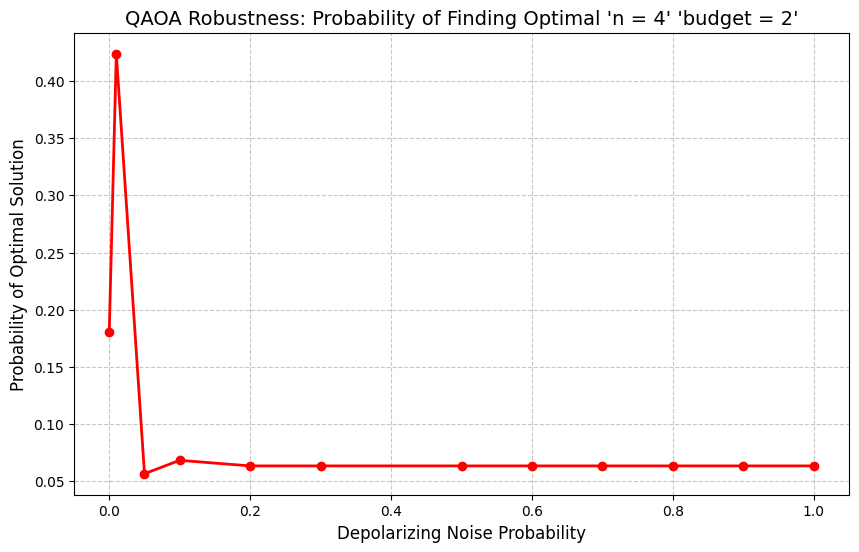

In [15]:
# Noise Analysis Parameters (defined again because of simulation time)
iter_noise=200
p_noise = 2
n_noise = 4
q_noise = 0.5
budget_noise = n_noise//2
penalty_noise = n_noise

# Fetch and prepare data for noise analysis
tickers_noise = get_famous_tickers(n_noise)
print("Selected Tickers for Noise Analysis:", tickers_noise)
mu, sigma, data = get_portfolio_data(tickers=tickers_noise, start_date="2016-01-01", end_date="2016-12-30", num_assets=n_noise)
mu_normalized, sigma_normalized = normalize_data(mu, sigma)

# Create Quadratic Program for noise analysis
qp_noise, portfolio = create_portfolio_qp(mu_normalized, sigma_normalized, q_noise, budget_noise)

# Run it
noise_levels = [0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
run_noise_analysis_prob(qp_noise, penalty_noise, p_noise, noise_levels, n_noise, budget_noise)